Loading facebook_combined.txt ...
✅ Loaded 4039 nodes, 88234 edges
Largest CC: 4039 nodes, 88234 edges
Average clustering: 0.6055
Triangles: 1612010
Fraction closed triangles: 0.5192
Computing layout (spring)...


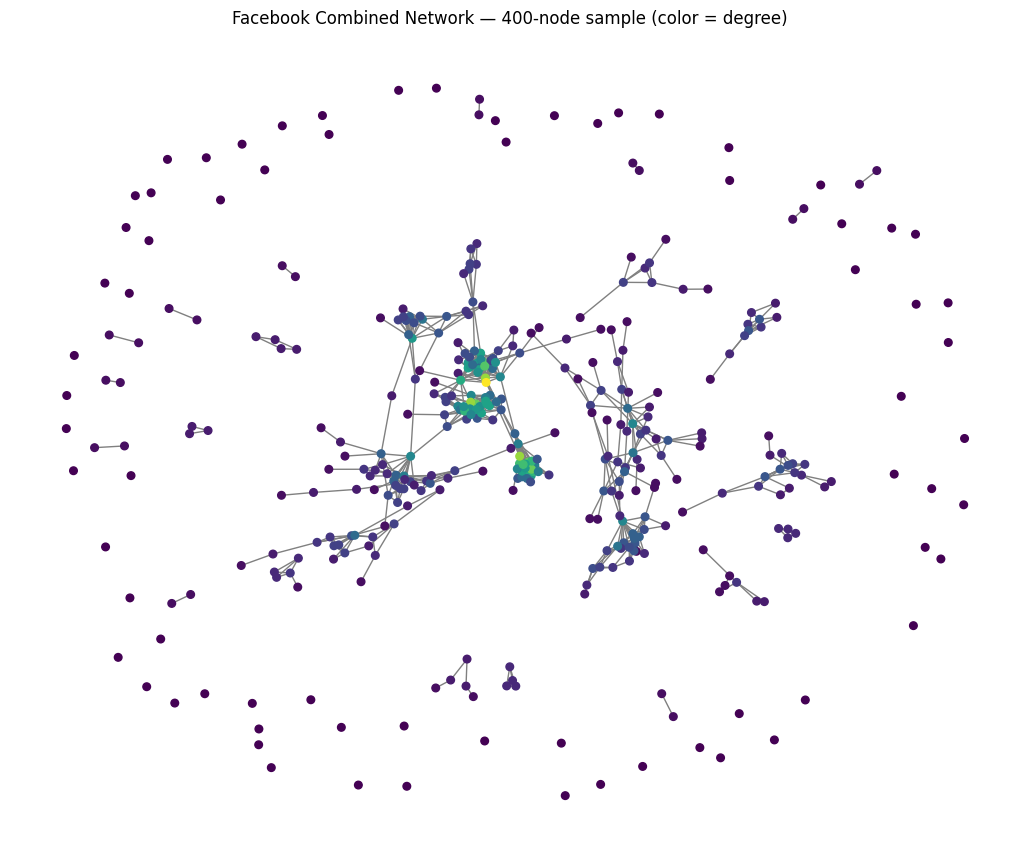

In [16]:
# -------------------------------
# Facebook Combined Network Visualization
# -------------------------------

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from pyvis.network import Network   # pip install pyvis

# 1. Load the full graph
print("Loading facebook_combined.txt ...")
G = nx.read_edgelist("facebook_combined.txt")
print(f"✅ Loaded {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# 2. Extract largest connected component
largest_cc = max(nx.connected_components(G), key=len)
Gcc = G.subgraph(largest_cc).copy()
print(f"Largest CC: {Gcc.number_of_nodes()} nodes, {Gcc.number_of_edges()} edges")

# 3. Compute basic metrics
clust = nx.average_clustering(Gcc)
triangles = sum(nx.triangles(Gcc).values()) / 3
closed_tri_frac = nx.transitivity(Gcc)
print(f"Average clustering: {clust:.4f}")
print(f"Triangles: {int(triangles)}")
print(f"Fraction closed triangles: {closed_tri_frac:.4f}")

# 4. Sample a subgraph for visualization (400 nodes)
sample_nodes = random.sample(list(Gcc.nodes()), 400)
H = Gcc.subgraph(sample_nodes)

# 5. Compute a quick layout
print("Computing layout (spring)...")
pos = nx.spring_layout(H, seed=42, iterations=30)

# 6. Color nodes by degree
deg = dict(H.degree())
colors = [deg[n] for n in H.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(
    H, pos,
    node_color=colors,
    cmap=plt.cm.viridis,
    node_size=30,
    edge_color="gray",
    with_labels=False
)
plt.title("Facebook Combined Network — 400-node sample (color = degree)")
plt.show()



In [ ]:
print(len(G), "nodes")
